## Import Packages

In [177]:
import pandas as pd
import numpy as np
import gseapy as gp
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from ipywidgets import widgets
from IPython.display import display

%matplotlib inline

## Class Definition

In [178]:
class PrepGsea:
    
    def __init__(self, gmt_file, expression_file, meta_file, output_dir, display_df_meta = True):
        
        self.gmt_file = gmt_file 
        self.expression_file = expression_file
        self.meta_file = meta_file
        self.output_dir = output_dir
        
        self.df_meta = pd.read_csv(meta_file)
        if display_df_meta == True: # recommended so that you can see your class and control choices
            print "Meta DataFrame: "
            display(self.df_meta)
    
    def choose_class_col(self, sample_col_name = 'sample'):
        
        self.col_headers = list(self.df_meta)
        self.sample_col_name = sample_col_name
        
        self.col_headers = [header for header in self.col_headers if sample_col_name not in header.lower()]

        print 'Please choose a class from the following list.\n\n' \
                     + 'Do not reload cell after marking your choice.\n' \
                     + 'Mark your choice before proceding.'
        
        self.class_col_button = widgets.RadioButtons(
            options = self.col_headers,
            description='Class options:',
            style = {'description_width': 'initial'},
            disabled=False
        )
        
        display(self.class_col_button)
        
    def choose_two_classes(self):
        
        print 'Please specify the two classes you wish to compare for class \"' + str(self.class_col_button.value) + '\".\n\n' \
                     + 'Do not reload cell after typing your choices.\n' \
                     + 'Type your choices before proceding.\n' \
                     + 'Reload this cell if the correct class isn\'t showing'

        class_name = self.class_col_button.value
        self.class_A_textbox = widgets.Text(description = class_name + ' class 1: ', style = {'description_width': 'initial'})
        self.class_B_textbox = widgets.Text(description = class_name + ' class 2: ', style = {'description_width': 'initial'})
        display(self.class_A_textbox)
        display(self.class_B_textbox)
        
    def choose_controls(self):
        
        class_A = self.class_A_textbox.value
        class_B = self.class_B_textbox.value
        class_name = self.class_col_button.value

        if class_name in self.col_headers:
            self.col_headers.remove(class_name)

        print 'Please specify your control values for each of the following.\n\n' \
             + 'Do not reload cell after typing your choices.\n' \
             + 'Type your choices before proceding.'
        
        self.controls_widget_array = []
        for header in self.col_headers:
            if self.sample_col_name not in header.lower():
                text = widgets.Text(description = header, style = {'description_width': 'initial'})
                display(text)
                self.controls_widget_array.append(text)
                
    def filter_metafile(self):
        
        # remember user preferences
        class_A = self.class_A_textbox.value
        class_B = self.class_B_textbox.value
        class_name = self.class_col_button.value
                
        # capture control values
        self.controls = {}
        for col, text in zip(self.col_headers, self.controls_widget_array):
            self.controls[col] = text.value
            
        print 'Filtering metafile by the following classes and controls:\n\n' \
        + 'class name: ' + str(class_name) + '\n' \
        + str(class_name) + ' value 1: ' + str(class_A) + '\n' \
        + str(class_name) + ' value 2: ' + str(class_B) + '\n\n' \
        + 'controls: '
        
        for k,v in self.controls.items():
            print str(k) + ': ' + str(v)
        
        print '\nPlease confirm that all the information above is correct.\n'
        
        # filter by control values
        for key, value in self.controls.iteritems(): 
            self.df_meta = self.df_meta[self.df_meta[key]==value]
        
        # filter by class name
        self.samp_to_class = self.df_meta[['Sample_name', class_name]]
        self.samp_to_class = self.samp_to_class[(self.samp_to_class[class_name] == class_A) | (self.samp_to_class[class_name] == class_B)]
        
        display(self.df_meta)
        
    def filter_expression_file(self, sample_col_name = 'Sample_name'):
        
            # remember user preferences
            class_A = self.class_A_textbox.value
            class_B = self.class_B_textbox.value
            class_name = self.class_col_button.value

            # load and display expression file
            self.df_expression = pd.read_table(self.expression_file, index_col='Unnamed: 0')
            focal_samples = list(self.df_expression)  # header

            # filter netafile by samples
            self.df_meta = df_meta[df_meta[sample_col_name].isin(focal_samples)]

            # filter metafile by controls
            for key, value in controls.iteritems(): 
                self.df_meta = self.df_meta[self.df_meta[key]==value]

            print "Expression file before filtering: " + str(self.df_expression.shape)
            display(self.df_expression.head())
            print "\nFiltered meta file: " + str(self.df_meta.shape)
            display(self.df_meta)
            
            # extract only the COLUMNS with sample_name and class name
            self.samp_to_class = self.df_meta[['Sample_name', class_name]]

            # only keep the rows with class_A and class_B
            self.samp_to_class = self.samp_to_class[(self.samp_to_class[class_name] == class_A) | (self.samp_to_class[class_name] == class_B)]
            
            # Filter expression file
            real_focal_samples = self.samp_to_class['Sample_name'].tolist()
            self.df_expression = self.df_expression[real_focal_samples]
            
            cap_gene = [str(g).upper() for g in self.df_expression.index.tolist()] # cap the genes
            self.df_expression['Name'] = cap_gene                                  # create a new column
            self.df_expression = self.df_expression[['Name'] + real_focal_samples] # put the 'Name' column at front
            self.df_expression.index = range(0,len(df_expression))                 # number the rows
            
            print "\nFiltered expression file: " + str(self.df_expression.shape)
            display(self.df_expression.head())
            
            self.cls_list = self.samp_to_class[class_name].tolist()
            if check_list(self.cls_list) == False:
                print '\nWarning: Your class column contains only one value. It should contain two. GSEA may not work under these circumstances.'
            
    def call_gsea(self,
              method = 'log2_ratio_of_classes',
              processes = 4,    ## 1 is default
              format = 'png',
              permutation_num = 100, # reduce number to speed up test
              weighted_score_type = 1,  # default: 1
             ):
    
        print "This may take a few minutes."
        self.gs_res = gp.gsea(data = self.df_expression, 
                              gene_sets = self.gmt_file,
                              cls = self.cls_list, 
                              permutation_num = permutation_num,
                              weighted_score_type = weighted_score_type,
                              outdir = self.output_dir,
                              method = method,
                              processes = processes,    ## 1 is default
                              format = format)

        #access the dataframe results throught res2d attribute
        return self.gs_res.res2d.head()
    
    def plot_gsea(self, style_content = 'ggplot', top = 20, y = 'fdr', x = 'Term', fontsize = 8):
        gsea_results = self.gs_res.res2d
        with plt.style.context(style_content):
            gsea_results = gsea_results.reset_index()
            gsea_results.head(top).plot.barh(y = y, x = x, fontsize = fontsize)
    
    def check_list(curr_list):
        first = curr_list[0]
        for obj in curr_list:
            if obj != first:
                return True
        return False

## User Preferences for Metafile Filtering

In [179]:
gsea_prepper = PrepGsea(gmt_file = '../../gseapy_databases/h.all.v6.1.symbols.gmt',
                            expression_file = '../../gseapy_databases/exp_ALCvsCHOWinNTinAlbCre.tsv',
                            meta_file = '../../gseapy_databases/dHEP_metadata.csv',
                            output_dir = '/../../gseapy_databases/mouse_liver_output')

Meta DataFrame: 


,Sample_name,Sample_Name2,mouse genotype,short_genotype,Model,Treatment,Tissue
0,dHEP_518_A_NT,dHEP-518-A-NT,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
1,dHEP_520_A_NT,dHEP-520-A-NT,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
2,dHEP_549_A_NT,dHEP-549-A-NT,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
3,dHEP_550_A_NT,dHEP-550-A-NT,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
4,F_F_503_A_NT,F/F-503-A-NT,IL-17RA-flox/flox,IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
5,F_F_523_A_NT,F/F-523-A-NT,IL-17RA-flox/flox,IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
6,F_F_581_A_NT,F/F-581-A-NT,IL-17RA-flox/flox,IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
7,F_F_595_A_NT,F/F-595-A-NT,IL-17RA-flox/flox,IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
8,dHEP_155_NC_NT,dHEP-155-NC-NT,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_only,Liver
9,dHEP_164_NC_NT,dHEP-164-NC-NT,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_only,Liver


In [180]:
gsea_prepper.choose_class_col()

Please choose a class from the following list.

Do not reload cell after marking your choice.
Mark your choice before proceding.


A Jupyter Widget

In [181]:
# Please enter the following:

# Tissue class 1: Liver
# Tissue class 2: liver_tumor

gsea_prepper.choose_two_classes() # text must match exactly what's in your meta dataframe

Please specify the two classes you wish to compare for class "Tissue".

Do not reload cell after typing your choices.
Type your choices before proceding.
Reload this cell if the correct class isn't showing


A Jupyter Widget

A Jupyter Widget

In [182]:
# Please enter the following:

# mouse genotype: Alb-Cre;IL-17RA-flox/flox
# short_genotype: AlbCre_IL17RA_floxflox
# Model: DEN   *** THERE IS A SPACE AT THE END ***
# Treatment: DEN_HFD_alcohol

gsea_prepper.choose_controls() # text must match exactly what's in your meta dataframe

Please specify your control values for each of the following.

Do not reload cell after typing your choices.
Type your choices before proceding.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [183]:
gsea_prepper.filter_metafile()

Filtering metafile by the following classes and controls:

class name: Tissue
Tissue value 1: Liver
Tissue value 2: liver_tumor

controls: 
mouse genotype: Alb-Cre;IL-17RA-flox/flox
short_genotype: AlbCre_IL17RA_floxflox
Model: DEN 
Treatment: DEN_HFD_alcohol

Please confirm that all the information above is correct.



,Sample_name,Sample_Name2,mouse genotype,short_genotype,Model,Treatment,Tissue
0,dHEP_518_A_NT,dHEP-518-A-NT,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
1,dHEP_520_A_NT,dHEP-520-A-NT,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
2,dHEP_549_A_NT,dHEP-549-A-NT,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
3,dHEP_550_A_NT,dHEP-550-A-NT,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
14,dHEP_518_A_T1,dHEP-518-A-T1,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,liver_tumor
15,dHEP_520_A_T,dHEP-520-A-T,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,liver_tumor
16,dHEP_549_A_T,dHEP-549-A-T,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,liver_tumor
17,dHEP_550_A_T,dHEP-550-A-T,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,liver_tumor


## Filter Expression File

In [184]:
gsea_prepper.filter_expression_file()

Expression file before filtering: (12651, 14)


,dHEP_520_A_NT,dHEP_550_A_NT,F_F_158_NC_NT,dHEP_549_A_NT,F_F_503_A_NT,dHEP_165_NC_NT,F_F_595_A_NT,F_F_523_A_NT,F_F_157_NC_NT,dHEP_518_A_NT,dHEP_164_NC_NT,dHEP_155_NC_NT,F_F_159_NC_NT,F_F_581_A_NT
Gnai3,6.482501,6.648272,6.644257,6.734103,6.557685,6.672892,6.707925,6.591240,6.632168,6.483054,6.815480,6.667075,6.768433,6.708067
Cdc45,0.779113,0.881496,0.026606,0.036682,0.688223,0.222011,0.281181,0.493432,0.192387,1.325266,1.160785,0.731233,0.930572,0.931043
Apoh,10.437362,10.285868,10.683067,10.462445,10.204836,10.558875,10.289569,10.032467,10.643058,10.364403,10.533293,10.551628,10.831810,10.346315
Narf,5.990224,6.089289,5.152588,6.280477,6.093053,6.277727,6.377708,5.902462,5.912509,6.144837,6.152632,5.551067,5.925389,6.137725
Cav2,1.732318,2.221725,2.069250,2.199621,1.634452,2.148011,2.390303,2.233464,1.226334,1.180876,2.263471,2.416598,1.768019,2.586876



Filtered meta file: (4, 7)


,Sample_name,Sample_Name2,mouse genotype,short_genotype,Model,Treatment,Tissue
0,dHEP_518_A_NT,dHEP-518-A-NT,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
1,dHEP_520_A_NT,dHEP-520-A-NT,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
2,dHEP_549_A_NT,dHEP-549-A-NT,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver
3,dHEP_550_A_NT,dHEP-550-A-NT,Alb-Cre;IL-17RA-flox/flox,AlbCre_IL17RA_floxflox,DEN,DEN_HFD_alcohol,Liver



Filtered expression file: (12651, 5)


,Name,dHEP_518_A_NT,dHEP_520_A_NT,dHEP_549_A_NT,dHEP_550_A_NT
0,GNAI3,6.483054,6.482501,6.734103,6.648272
1,CDC45,1.325266,0.779113,0.036682,0.881496
2,APOH,10.364403,10.437362,10.462445,10.285868
3,NARF,6.144837,5.990224,6.280477,6.089289
4,CAV2,1.180876,1.732318,2.199621,2.221725


In [185]:
gsea_prepper.cls_list = ['Liver', 'Liver', 'liver_tumor', 'liver_tumor'] # I made bad filtering decisions. See Warning above
gsea_prepper.call_gsea(method = 'log2_ratio_of_classes',
          processes = 4,
          format = 'png',
          permutation_num = 100,
          weighted_score_type = 1)

2018-04-16 11:29:30,352 Warning: dropping duplicated gene names, only keep the first values


This may take a few minutes.


,es,nes,pval,fdr,geneset_size,matched_size,genes
Term,,,,,,,
HALLMARK_ADIPOGENESIS,NaN,0.0,0.0,1.0,200,187,"BCL6,GADD45A,LIPE,FZD4,OMD,TOB1,PHLDB1,SLC27A1..."
HALLMARK_KRAS_SIGNALING_DN,NaN,0.0,0.0,1.0,200,71,"KLHDC8A,ATP4A,TCF7L1,EDN1,P2RY4,H2AFY2,GTF3C5,..."
HALLMARK_KRAS_SIGNALING_UP,NaN,0.0,0.0,1.0,200,148,"PPBP,PRDM1,IL7R,CXCL10,SOX9,SATB1,ITGA2,PRRX1,..."
HALLMARK_MITOTIC_SPINDLE,NaN,0.0,0.0,1.0,200,189,"CENPE,BIRC5,ECT2,NUSAP1,CENPF,PRC1,SASS6,LMNB1..."
HALLMARK_MTORC1_SIGNALING,NaN,0.0,0.0,1.0,200,188,"VLDLR,AURKA,IGFBP5,BTG2,BHLHE40,FDXR,ELOVL5,CO..."


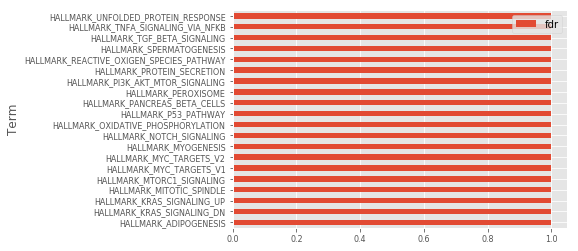

In [187]:
gsea_prepper.plot_gsea(style_content = 'ggplot', top = 20, y = 'fdr', x = 'Term', fontsize = 8)